In [130]:
import os 
import re 
from pathlib import Path
from static_autoencoder_tutorial.src.helpers import models, data
import torch.nn as nn
import torch 
from importlib import reload 
import pandas as pd 
reload(models)

path_to_models = '/Users/ryanstevens/Documents/github/torch_practice/data/models/static/'
INPUT_DIM = 28*28
compression_per_layer = {
    1: 16,
    64: 2,
    128: 2,
    256: 2,
    28*28: 2
}

train, val, test = data.load_and_preprocess_data(debug=False, batch_size=1)
test_error_df = pd.DataFrame(None)
train_error_df = pd.DataFrame(None)
latent_dims_run = []
for path_to_model in os.listdir(path_to_models):
    latent_dim, batch_size = re.findall('\d+', path_to_model)

    if int(batch_size) != 4:
        continue 
    if latent_dim in latent_dims_run:
        continue 

    
    path_to_model_checkpoint = Path(path_to_models) / path_to_model / 'checkpoint.pt'

    if not os.path.isfile(path_to_model_checkpoint):
        continue 
    
    print(f'running {latent_dim}')
    latent_dims_run.append(latent_dim)

    latent_dim = int(latent_dim)
    # Initialize model
    encoder_decoder_model = models.StaticEncoderDecoder(
        input_dim=INPUT_DIM,
        latent_dim=latent_dim,
        head_layer=nn.Sigmoid(),
        compression_per_layer=compression_per_layer[latent_dim],
    )
    encoder_decoder_model_decoder_only = models._StaticEncoderDecoder_BottleNeckLayer(
        input_dim=INPUT_DIM,
        latent_dim=latent_dim,
        head_layer=nn.Sigmoid(),
        compression_per_layer=compression_per_layer[latent_dim],
    )

    # Load model weights
    encoder_decoder_model.load_state_dict(torch.load(path_to_model_checkpoint))
    encoder_decoder_model_decoder_only.load_state_dict(torch.load(path_to_model_checkpoint))

    train_avg_embedding=np.zeros((1, int(latent_dim)))
    n_train = 0
    for X, label in train:
        y_pred=encoder_decoder_model(X)
        autoencoder_error=nn.CrossEntropyLoss()(y_pred, X)
        train_avg_embedding+=encoder_decoder_model_decoder_only(X).detach().numpy()
        train_data.append(
            (
                label[0],
                float(autoencoder_error.detach()),
                latent_dim
            )
        ) 
        n_train += 1

    train_avg_embedding = train_avg_embedding/n_train

    train_data=[]
    for X, label in train:
        y_pred=encoder_decoder_model(X)
        autoencoder_error=nn.CrossEntropyLoss()(y_pred, X)
        y_pred_embedding=encoder_decoder_model_decoder_only(X).detach().numpy()
        train_data.append(
            (
                label[0],
                float(autoencoder_error.detach()),
                np.dot(y_pred_embedding, np.transpose(train_avg_embedding))[0][0],
                latent_dim
            )
        ) 

    test_data=[]
    for X, label in test:
        if float(label[0])==0.0:
            is_outlier=True 
        else:
            is_outlier=False
        y_pred=encoder_decoder_model(X)
        y_pred_embedding=encoder_decoder_model_decoder_only(X).detach().numpy()
        autoencoder_error=nn.CrossEntropyLoss()(y_pred, X)
        test_data.append(
            (
                label[0],
                is_outlier,
                float(autoencoder_error.detach()),
                np.dot(y_pred_embedding, np.transpose(train_avg_embedding))[0][0],
                latent_dim
            )
        ) 

    

    
    test_error_df = pd.concat([test_error_df, pd.DataFrame(test_data, columns=['label', 'is_outlier', 'error', 'embedding_dot_product', 'latent_dim'])])
    train_error_df = pd.concat([train_error_df, pd.DataFrame(train_data, columns=['label', 'error', 'embedding_dot_product', 'latent_dim'])])


running 1
running 64
running 256
running 128


Text(0.5, 1.0, 'Median Reconstruction Loss\nBy Bottleneck Layer Size')

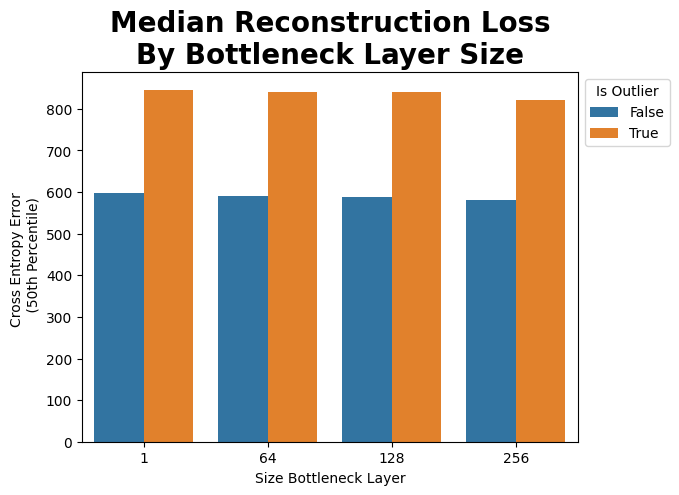

In [76]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt_df=test_error_df.groupby(['is_outlier', 'latent_dim'])['error'].quantile([0.5]).reset_index()
plt_df=plt_df.rename(
    columns={
        'level_2': 'percentile'
    }
)

fig, ax = plt.subplots(1)

sns.barplot(
    data=plt_df, 
    y='error',
    x='latent_dim',
    hue='is_outlier'
)
leg=ax.legend(
    bbox_to_anchor=(1.0, 1.0),
    title='Is Outlier'
)
ax.set_ylabel('Cross Entropy Error \n (50th Percentile)')
ax.set_xlabel('Size Bottleneck Layer')

plt.title(
    'Median Reconstruction Loss\nBy Bottleneck Layer Size',
    fontsize=20,
    fontweight='bold'
)

In [83]:
# Compute mean, standard deviation of reconstruction loss 
train_summ_stats=train_error_df.groupby('latent_dim')['error'].agg(['mean', 'var']).reset_index()
test_error_df=pd.merge(
    test_error_df,
    train_summ_stats,
    on='latent_dim'
)
test_error_df['z_score']=(test_error_df['error'] - test_error_df['mean'])/(test_error_df['var']**(1/2))

In [96]:
test_error_df['pred_outlier'] = test_error_df['z_score'] >= 2.5
raw_classification_counts=test_error_df.groupby(['latent_dim', 'is_outlier', 'pred_outlier']).count().reset_index()[['latent_dim', 'is_outlier', 'pred_outlier', 'z_score']].rename(columns={'z_score': 'n'})

/var/folders/gm/3_f0k59n1tx3755nd8s4hjj40000gn/T/ipykernel_88991/69458069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precision['perc']=precision.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
/var/folders/gm/3_f0k59n1tx3755nd8s4hjj40000gn/T/ipykernel_88991/69458069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall['perc']=recall.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values


Text(0.5, 1.0, 'Evaluation Metrics\nZ-Score Classifier')

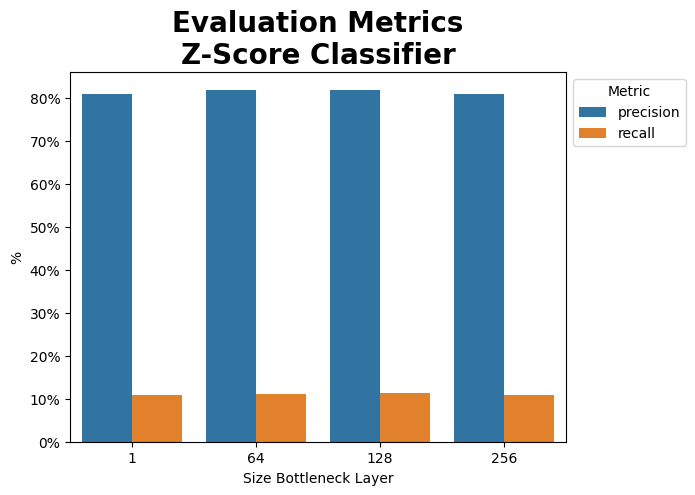

In [117]:
import matplotlib.ticker as ticker 

precision=raw_classification_counts.query("pred_outlier == True")
precision['perc']=precision.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
precision=precision.query("is_outlier==True").drop(['n', 'is_outlier', 'pred_outlier'], axis=1).assign(hue='precision')

recall=raw_classification_counts.query("is_outlier == True")
recall['perc']=recall.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
recall=recall.query("pred_outlier==True").drop(['n', 'is_outlier', 'pred_outlier'], axis=1).assign(hue='recall')

summ_stats = pd.concat(
   [precision,
    recall
   ],
    axis=0
)

fig, ax = plt.subplots(1)

sns.barplot(
    data=summ_stats,
    x='latent_dim',
    y='perc',
    hue='hue'
)

ax.set_xlabel('Size Bottleneck Layer')
leg=ax.legend(
    bbox_to_anchor=(1.0, 1.0),
    title='Metric'
)
ax.set_ylabel('%')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.title(
    'Evaluation Metrics\nZ-Score Classifier',
    fontsize=20,
    fontweight='bold'
)



Text(0.5, 1.0, 'Median Distance Embeddings\nBy Bottleneck Layer Size')

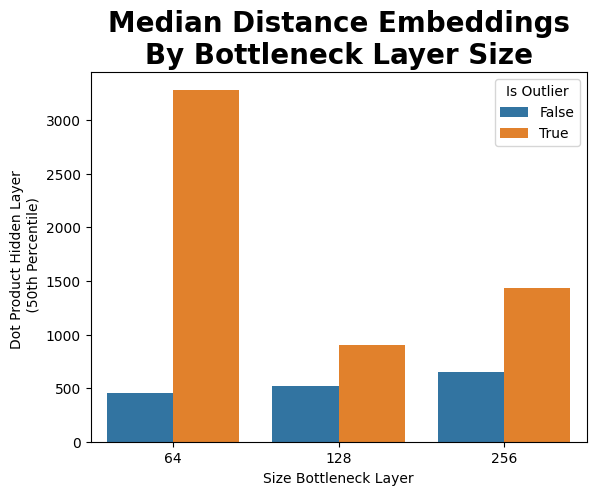

In [133]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt_df=test_error_df.groupby(['is_outlier', 'latent_dim'])['embedding_dot_product'].quantile([0.5]).reset_index()
plt_df=plt_df.rename(
    columns={
        'level_2': 'percentile'
    }
)

fig, ax = plt.subplots(1)

sns.barplot(
    data=plt_df.query("latent_dim != 1"), 
    y='embedding_dot_product',
    x='latent_dim',
    hue='is_outlier'
)
leg=ax.legend(
    bbox_to_anchor=(1.0, 1.0),
    title='Is Outlier'
)
ax.set_ylabel('Dot Product Hidden Layer \n (50th Percentile)')
ax.set_xlabel('Size Bottleneck Layer')

plt.title(
    'Median Distance Embeddings\nBy Bottleneck Layer Size',
    fontsize=20,
    fontweight='bold'
)

In [137]:
# Compute mean, standard deviation of reconstruction loss 
try: 
    del test_error_df['mean']
    del test_error_df['var']
except:
    pass 
train_summ_stats=train_error_df.groupby('latent_dim')['embedding_dot_product'].agg(['mean', 'var']).reset_index()
test_error_df=pd.merge(
    test_error_df,
    train_summ_stats,
    on='latent_dim'
)
test_error_df['z_score']=(test_error_df['embedding_dot_product'] - test_error_df['mean'])/(test_error_df['var']**(1/2))
test_error_df['pred_outlier'] = test_error_df['z_score'].apply(lambda x: abs(x) >= 3)

In [140]:
raw_classification_counts=test_error_df.groupby(['latent_dim', 'is_outlier', 'pred_outlier']).count().reset_index()[['latent_dim', 'is_outlier', 'pred_outlier', 'z_score']].rename(columns={'z_score': 'n'})

/var/folders/gm/3_f0k59n1tx3755nd8s4hjj40000gn/T/ipykernel_88991/353167242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precision['perc']=precision.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
/var/folders/gm/3_f0k59n1tx3755nd8s4hjj40000gn/T/ipykernel_88991/353167242.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall['perc']=recall.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values


Text(0.5, 1.0, 'Evaluation Metrics\nZ-Score Classifier')

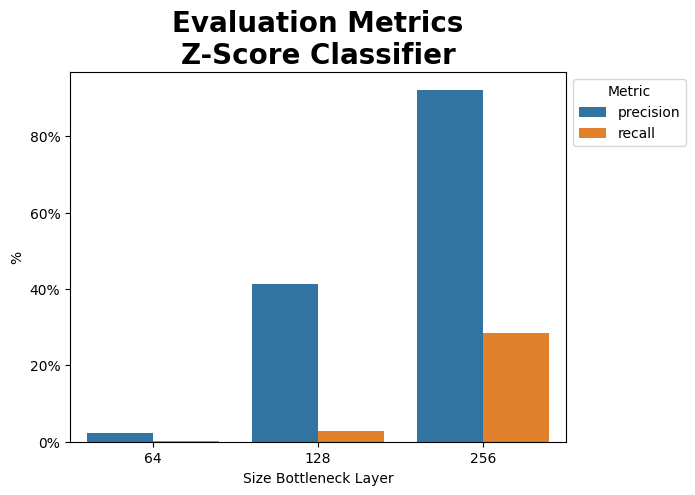

In [142]:
import matplotlib.ticker as ticker 

precision=raw_classification_counts.query("pred_outlier == True")
precision['perc']=precision.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
precision=precision.query("is_outlier==True").drop(['n', 'is_outlier', 'pred_outlier'], axis=1).assign(hue='precision')

recall=raw_classification_counts.query("is_outlier == True")
recall['perc']=recall.groupby('latent_dim')['n'].apply(lambda x: x/x.sum()).values
recall=recall.query("pred_outlier==True").drop(['n', 'is_outlier', 'pred_outlier'], axis=1).assign(hue='recall')

summ_stats = pd.concat(
   [precision,
    recall
   ],
    axis=0
)

fig, ax = plt.subplots(1)

sns.barplot(
    data=summ_stats.query("latent_dim != 1"),
    x='latent_dim',
    y='perc',
    hue='hue'
)

ax.set_xlabel('Size Bottleneck Layer')
leg=ax.legend(
    bbox_to_anchor=(1.0, 1.0),
    title='Metric'
)
ax.set_ylabel('%')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.title(
    'Evaluation Metrics\nZ-Score Classifier',
    fontsize=20,
    fontweight='bold'
)



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt 
from glob import glob 
from pathlib import Path 
import numpy as np 

def create_gif_from_arrays(
    path_to_root: str,
    latent_dim: int, 
    batch_size: int, 
    model: str='static'
):

    # Path to prediction arrays 
    path_to_pred_arrays = [x for x in glob((Path(path_to_root) / model / f'latentDim={latent_dim}_batchSize={batch_size}' / '*').as_posix(), recursive=True) if 'gif' not in x]
    path_to_labels = Path(path_to_root) / 'validation_data'/ f'batchSize={batch_size}' / 'y.npy' 
    path_to_gif =  Path(path_to_root) / model / f'latentDim={latent_dim}_batchSize={batch_size}' / 'gif'
    path_to_gif.mkdir(parents=True, exist_ok=True)
    
    images={}
    for path_to_array in path_to_pred_arrays:
        with open(path_to_array, 'rb') as ifile:
            loaded_array=np.load(ifile)
            n_rows=loaded_array.shape[0]
            print(n_rows)
            for i in range(n_rows):
                # Save to png
                print(path_to_array.replace('.npy', f'{str(i)}.png'))
                print(loaded_array[i, :].shape)
                plt.imsave(
                    path_to_array.replace('.npy', f'{str(i)}.png'),
                    loaded_array[i, :].reshape(28, 28)
                )
                im=Image.open(path_to_array.replace('.npy', f'{str(i)}.png'))
                if i in images:
                    images[i].append(im)
                else:
                    images[i] = []
                Path(path_to_array.replace('.npy', f'{str(i)}.png')).unlink()

    with open(path_to_labels, 'rb') as i:
        labels=np.load(i)

    for k, v in images.items():
        v[0].save(
            path_to_gif / 'start.gif',
            append_images=v[1:],
            save_all=True, 
            # optimize=False, 
            duration=80, 
            loop=0
        )
        f = Image.open(path_to_gif /'start.gif')
        f.info['duration'] = 3000
        f.save(path_to_gif/f'example={k}_label={labels[k]}.gif', save_all=True)
        (path_to_gif/'start.gif').unlink()

for batch_size in [
    4, 
    16, 
    32]:

    for latent_dim, compression_per_layer in [
        (1, 16), 
        (64, 2), 
        (128, 2),
        (256, 2), 
        (28*28, 2)
    ]:

        create_gif_from_arrays(
            path_to_root='/Users/ryanstevens/Documents/github/torch_practice/data/batch_predictions/',
            latent_dim=latent_dim,
            batch_size=batch_size
        )